# Simulation of HPL on Paravance

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_result(name):
    archive = zipfile.ZipFile(name)
    return pandas.read_csv(io.BytesIO(archive.read('results.csv')))

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    install_options = get_yaml(name, installfile)
    result['stochastic_cpu'] = install_options['stochastic_cpu']
    result['polynomial_dgemm'] = install_options['polynomial_dgemm']
    result['stochastic_network'] = install_options['stochastic_network']
    result['heterogeneous_dgemm'] = install_options['heterogeneous_dgemm']
    return result

simulation_dir = '1/'
simulation_files = [simulation_dir + f for f in os.listdir(simulation_dir)]

reality_files = [
    '../hpl/rennes_2019-08-14_1178378.zip',
    '../hpl/rennes_2019-08-16_1179212.zip',
    '../hpl/rennes_2019-08-18_1179242.zip',
    '../hpl/rennes_2019-08-18_1179272.zip',
]

dfsim = pandas.concat([read_sim_result(f) for f in simulation_files])
dfsim['mode'] = 'Simulation'

dfreal = pandas.concat([read_result(f) for f in reality_files])
dfreal['mode'] = 'Reality'

df = pandas.concat([dfsim, dfreal])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,filename,gflops,heterogeneous_dgemm,major_page_fault,matrix_size,...,simulation_time,start_timestamp,stochastic_cpu,stochastic_network,stop_timestamp,swap,sys_time,thread_per_process,time,usr_time
0,126.160,2,128,0.99,1,1/nancy_2019-08-26_2051080.zip,3377.0,True,0.0,50000,...,908.25,NaN,True,False,NaN,0,63.28,1,24.68,839.67
1,178.373,2,128,0.99,1,1/nancy_2019-08-26_2051080.zip,5607.0,True,0.0,75000,...,1350.58,NaN,True,False,NaN,0,90.79,1,50.16,1257.26
2,232.087,2,128,0.99,1,1/nancy_2019-08-26_2051080.zip,7819.0,True,0.0,100000,...,1846.40,NaN,True,False,NaN,0,123.55,1,85.26,1716.08
3,293.933,2,128,0.99,1,1/nancy_2019-08-26_2051080.zip,9648.0,True,0.0,125000,...,2369.30,NaN,True,False,NaN,0,158.98,1,134.97,2205.44
4,347.415,2,128,0.99,1,1/nancy_2019-08-26_2051080.zip,11410.0,True,0.0,150000,...,2859.50,NaN,True,False,NaN,0,189.01,1,197.15,2660.43


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,process_per_node,proc_q,proc_p,swap,bcast,block_size,thread_per_process,depth,mem_align,pfact,rfact
0,16,32,32,0,2,128,1,1,8,1,2


In [3]:
dfsim[['stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm']].drop_duplicates()

,stochastic_cpu,polynomial_dgemm,stochastic_network,heterogeneous_dgemm
0,True,True,False,True


In [4]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### paravance.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.7108892118448524e-06:1.432753405704226e-10;1416:3.109310304245123e-06:6.438881093085975e-11;65480:0.0:0.0;129554:0.0:0.0;250309:0.0:0.0;385716:0.0:0.0"/>
        <prop id="smpi/or" value="0:4.3239492327926595e-06:1.2954254806034372e-09;1416:8.125102238821709e-06:3.387442613661333e-10;65480:0.0:0.0;129554:0.0:0.0;250309:0.0:0.0;385716:0.0:0.0"/>
        <prop id="smpi/ois" value="0:3.0060582233072994e-06:1.2949499332161986e-10;1416:3.3131664831673444e-06:6.16072310283857e-11;65480:3.017881498809607e-06:3.356979717441256e-12;129554:3.2251735956609496e-06:1.7313977471279236e-13;250309:3.229893975987937e-06:2.7016520591770337e-13;385716:3.2105154072169426e-06:2.478497528158371e-13"/>
        <prop id="smpi/bw-factor" value="0:0.043117740751190896;1416:1.0858686867111624;65480:0.629868292975373;129554:0.8107193845607635;250309:0.739581541304429;385716:0.6996165497807703"/>
        <prop id="smpi/lat-factor" value="0:1.045872482413566;1416:2.257283145959299;65480:4.4968348633736905;129554:8.986088815194826;250309:8.523555537742846;385716:7.831615753631102"/>
        <prop id="smpi/async-small-thresh" value="65480"/>
        <prop id="smpi/send-is-detached-thresh" value="65480"/>
        <prop id="smpi/iprobe" value="9.007824203737025e-07"/>
        <prop id="smpi/test" value="8.477165098573299e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="paravance-" suffix=".rennes.grid5000.fr" radical="1-72" speed="1" core="16" bw="1.25GBps" lat="10.00us" loopback_bw="15.76994752045981GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [5]:
patches = set()
for row in dfsim.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 70ccbce..0fd833b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -342,8 +342,6 @@ void HPL_dlacpy
 /*
  * End of HPL_dlacpy
  */
-#else
-   smpi_execute_normal_size(3.871806e-09, 1.328595e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 50d71eb..8bdca86 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -397,8 +397,6 @@ void HPL_dlatcpy
 /*
  * End of HPL_dlatcpy
  */
-#else
-    smpi_execute_normal_size(4.893900e-09, 4.691039e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp01T.c b/src/pauxil/HPL_dlaswp01T.c
index dc0f8b3..e0d8879 100644
--- a/src/pauxil/HPL_dlaswp01T.c
+++ b/src/pauxil/HPL_dlaswp01T.c
@@ -251,8 +251,6 @@ void HPL_dlaswp01T
 /*
  * End of HPL_dlaswp01T
  */
-#else
-    smpi_execute_normal_size(7.547639e-09, 1.371708e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp02N.c b/src/pauxil/HPL_dlaswp02N.c
index ba461fc..d7345d9 100644
--- a/src/pauxil/HPL_dlaswp02N.c
+++ b/src/pauxil/HPL_dlaswp02N.c
@@ -204,8 +204,6 @@ void HPL_dlaswp02N
 /*
  * End of HPL_dlaswp02N
  */
-#else
-    smpi_execute_normal_size(2.822241e-08, 5.497050e-09, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp03T.c b/src/pauxil/HPL_dlaswp03T.c
index 8e54bfe..92c4665 100644
--- a/src/pauxil/HPL_dlaswp03T.c
+++ b/src/pauxil/HPL_dlaswp03T.c
@@ -185,8 +185,6 @@ void HPL_dlaswp03T
 /*
  * End of HPL_dlaswp03T
  */
-#else
-    smpi_execute_normal_size(3.775240e-09, 2.968320e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp04T.c b/src/pauxil/HPL_dlaswp04T.c
index 61dd638..8e05cf3 100644
--- a/src/pauxil/HPL_dlaswp04T.c
+++ b/src/pauxil/HPL_dlaswp04T.c
@@ -269,8 +269,6 @@ void HPL_dlaswp04T
 /*
  * End of HPL_dlaswp04T
  */
-#else
-   smpi_execute_normal_size(8.498957e-09, 2.218070e-09, ((double)M1)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 3, (int []){M0, M1, N});
    

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index dd235b7..ab40276 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -204,14 +204,14 @@ double random_halfnormal_shifted(double exp, double std) {
 }

 void smpi_execute_normal(double mu, double sigma) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0) {
         smpi_execute_benched(coefficient);
     }
 }

 void smpi_execute_normal_size(double mu, double sigma, double size) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0 && size > 0) {
         smpi_execute_benched(size * coefficient);
     }
    
```

### Comparing the simulation with the real execution

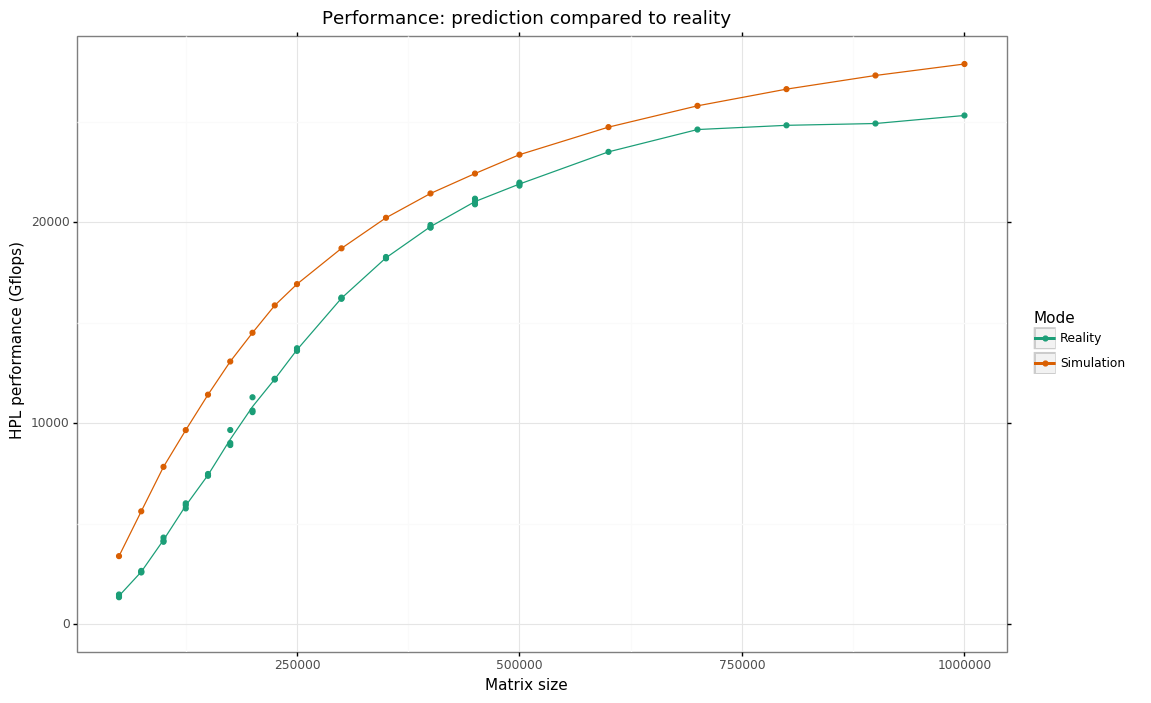

<ggplot: (-9223363309635520105)>

In [6]:
import numpy

plot = ggplot(df, aes(x='matrix_size', y='gflops', color='mode')) + theme_bw() + expand_limits(y=0)
plot = plot + geom_point() + stat_summary(fun_y = numpy.mean, geom='line')
plot = plot + scale_color_brewer(type='qual', palette='Dark2')
plot = plot + xlab('Matrix size') + ylab('HPL performance (Gflops)') + labs(color='Mode') + ggtitle('Performance: prediction compared to reality')
plot

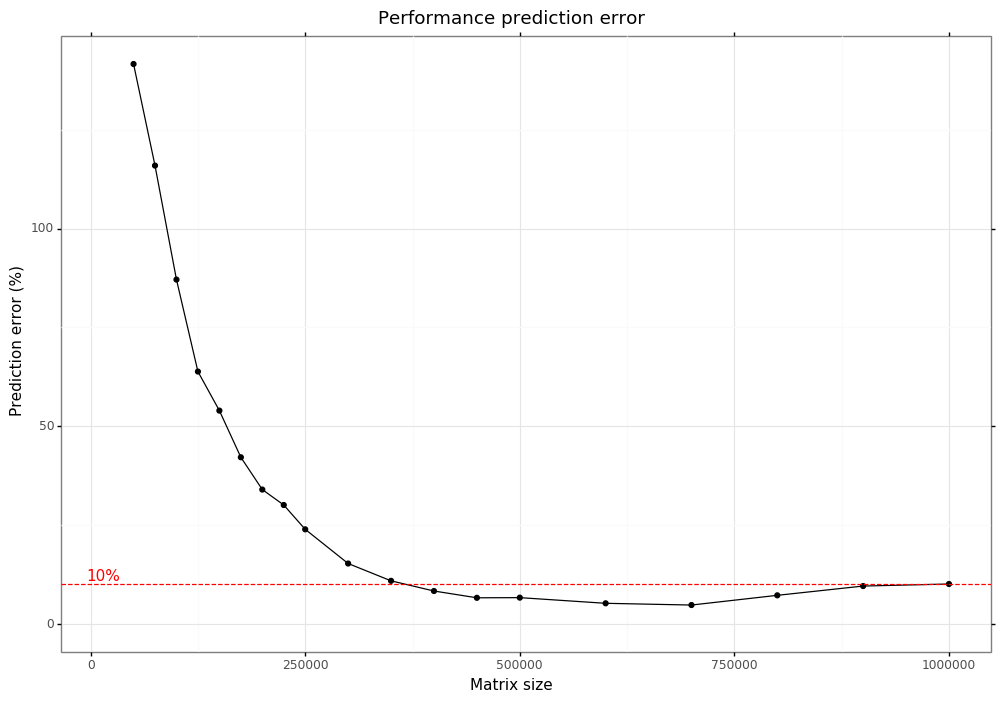

<ggplot: (8727212069759)>

In [7]:
dfreal = df[df['mode'] == 'Reality'].groupby('matrix_size').mean()
dfsim = df[df['mode'] == 'Simulation'].groupby('matrix_size').mean()
dfgrouped = dfreal.join(dfsim, on='matrix_size', lsuffix='_reality', rsuffix='_simulation').reset_index()
dfgrouped['error'] = (dfgrouped['gflops_simulation'] - dfgrouped['gflops_reality'])/dfgrouped['gflops_reality'] * 100

plot = ggplot(dfgrouped, aes(x='matrix_size', y='error')) + theme_bw() + expand_limits(y=0)
plot = plot + geom_point() + geom_line()
plot = plot + xlab('Matrix size') + ylab('Prediction error (%)') + ggtitle('Performance prediction error')
plot = plot + geom_hline(yintercept=10, color='red', linetype='dashed') + annotate('text', label='10%', x=15000, y=12, color='red')
plot